---

# <center>★ AI / ML Research Implementation - Inception V1 ★

<center><img src="https://github.com/Masterx-AI/Inception-V1-Implementaion/raw/main/InceptionV1.png" style="width: 600px;"/>

---

### Objective:
- Understand the Model Architecture
- Reconstruct the Model Architecture from scratch
- Perform a dry run test to assess it's implemenation on real-time data.

---

### Inception V1 Model Description:


In a traditional neural network layer or convolutional neural network layer, the output from the previous layer is the input for the next layer and follows that pattern until the prediction. The basic idea of the inception network is the inception block. It takes apart the individual layers and instead of passing it through 1 layer it takes the previous layer input and passes it to four different operations in parallel and then concatenates the outlets from all these different layers. Below is the figure of the inception block. Don’t worry about the picture you saw below, we will get into the details of it.

Let’s understand what is inception block and how it works. Google Net is made of 9 inception blocks. Before understanding inception blocks, I assume that you know about backpropagation concepts like scholastic gradient descent and CNN-related concepts like max-pooling, convolution, stride, and padding if not check out those concepts. Do note that, in the above image max-pooling is done using SAME pooling. you may get a doubt that what is SAME pooling? There are types of performing pooling like VALID pooling and SAME pooling.

In the above visualizations, the first one is VALID pooling where you don't apply any padding on the image. The third one is the SAME pooling. Here we apply padding to input (if needed) so that the input image gets fully covered by the filter and stride you specified. For stride 1, this will ensure that the output image size is the same as the input.

Now let’s see fig (a) and understand about inception block. In a traditional CNN architecture, the output of one layer is connected as an input of the Next Layer, but for the Inception block, each filter is applied separately to the previous layer output and finally, all the results are concatenated and sent as an input to the next layer. as we can see in fig (a), for 28x28x192 (height, width, channels) input, we applied 4 different filters 1x1, 3x3, 5x5, 3x3. Right now, you may have many doubts like why do we apply 1x1, 3x3, and 5x5 filters? And performing convolution using 1x1 will not give any changes, but still, why do we use a 1x1 filter?

In earlier architectures, they have fixed convolution size window, for example, in VGG16 the convolution filter is of size 3x3 and is fixed for all but here we use both 3x3 and 5x5 to address the different object sizes in the image. We apply a 1x1 filter to decrease the spectral dimension. Spectral dimension means band, for example, if an input size for an inception block is 28x28x192, then 192 is called a band or spectral dimension. If we reduce that spectral dimension using a 1x1 filter, we can save a lot of computational power. We also apply a 1x1 filter before applying 3x3 and 5x5 to save the computational resources. We will see how we will save computational power by using a 1x1 filter in detail.

---

## <center> Stractegic Plan of Action:
    
**We aim to solve the problem statement by creating a plan of action, Here are some of the necessary steps:**
1. Dataset Prepration
2. Model Development
3. Model Testing
4. Project Outcomes & Conclusion

---

## <center> 1. Dataset Prepration

In [1]:
#Importing the basic librarires

import cv2
import math
import keras
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras import backend as K 
from keras.utils import np_utils
from keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten

In [2]:
# Preparing the Dataset

num_classes = 10
img_rows,img_cols = 224, 224

# Load training and validation sets
(X_train, Y_train), (X_test, y_test) = cifar10.load_data()

# Resize images to 244x244
X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:][:3000]])
X_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_test[:,:,:,:][:3000]])
Y_train = Y_train[:3000]
y_test = y_test[:3000]

# Transform targets to keras compatible format
Y_train = np_utils.to_categorical(Y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Making all the values range between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train.shape, Y_train.shape, X_test.shape, y_test.shape

170508288/170498071 [==============================] - 3s 0us/step


((3000, 224, 224, 3), (3000, 10), (3000, 224, 224, 3), (3000, 10))

---

## <center>2. Model Development

In [3]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3,
    filters_5x5_reduce,filters_5x5,filters_pool_proj,name=None):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)
    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [4]:
# Building the Incpetion V1 Model Architecture

input_layer = Input(shape=(224, 224, 3))
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)
x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96, filters_3x3=128,filters_5x5_reduce=16, filters_5x5=32,filters_pool_proj=32, name='inception_3a')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=192,filters_5x5_reduce=32, filters_5x5=96,filters_pool_proj=64, name='inception_3b')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)
x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96, filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64, name='inception_4a')
x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(10, activation='softmax', name='auxilliary_output_1')(x1)
x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112, filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64,name='inception_4b')
x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64, filters_pool_proj=64,name='inception_4c')
x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144, filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64, filters_pool_proj=64, name='inception_4d')
x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(10, activation='softmax', name='auxilliary_output_2')(x2)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128, name='inception_4e')
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)
x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128, name='inception_5a')
x = inception_module(x, filters_1x1=384,filters_3x3_reduce=192, filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128, filters_pool_proj=128, name='inception_5b')
x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)
x = Dropout(0.4)(x)
x = Dense(10, activation='softmax', name='output')(x)

model = Model(input_layer, [x, x1, x2], name='inception_v1')

# Compiling the Model
model.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

# Checking Model Summary
model.summary()

2022-06-26 15:36:31.827227: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

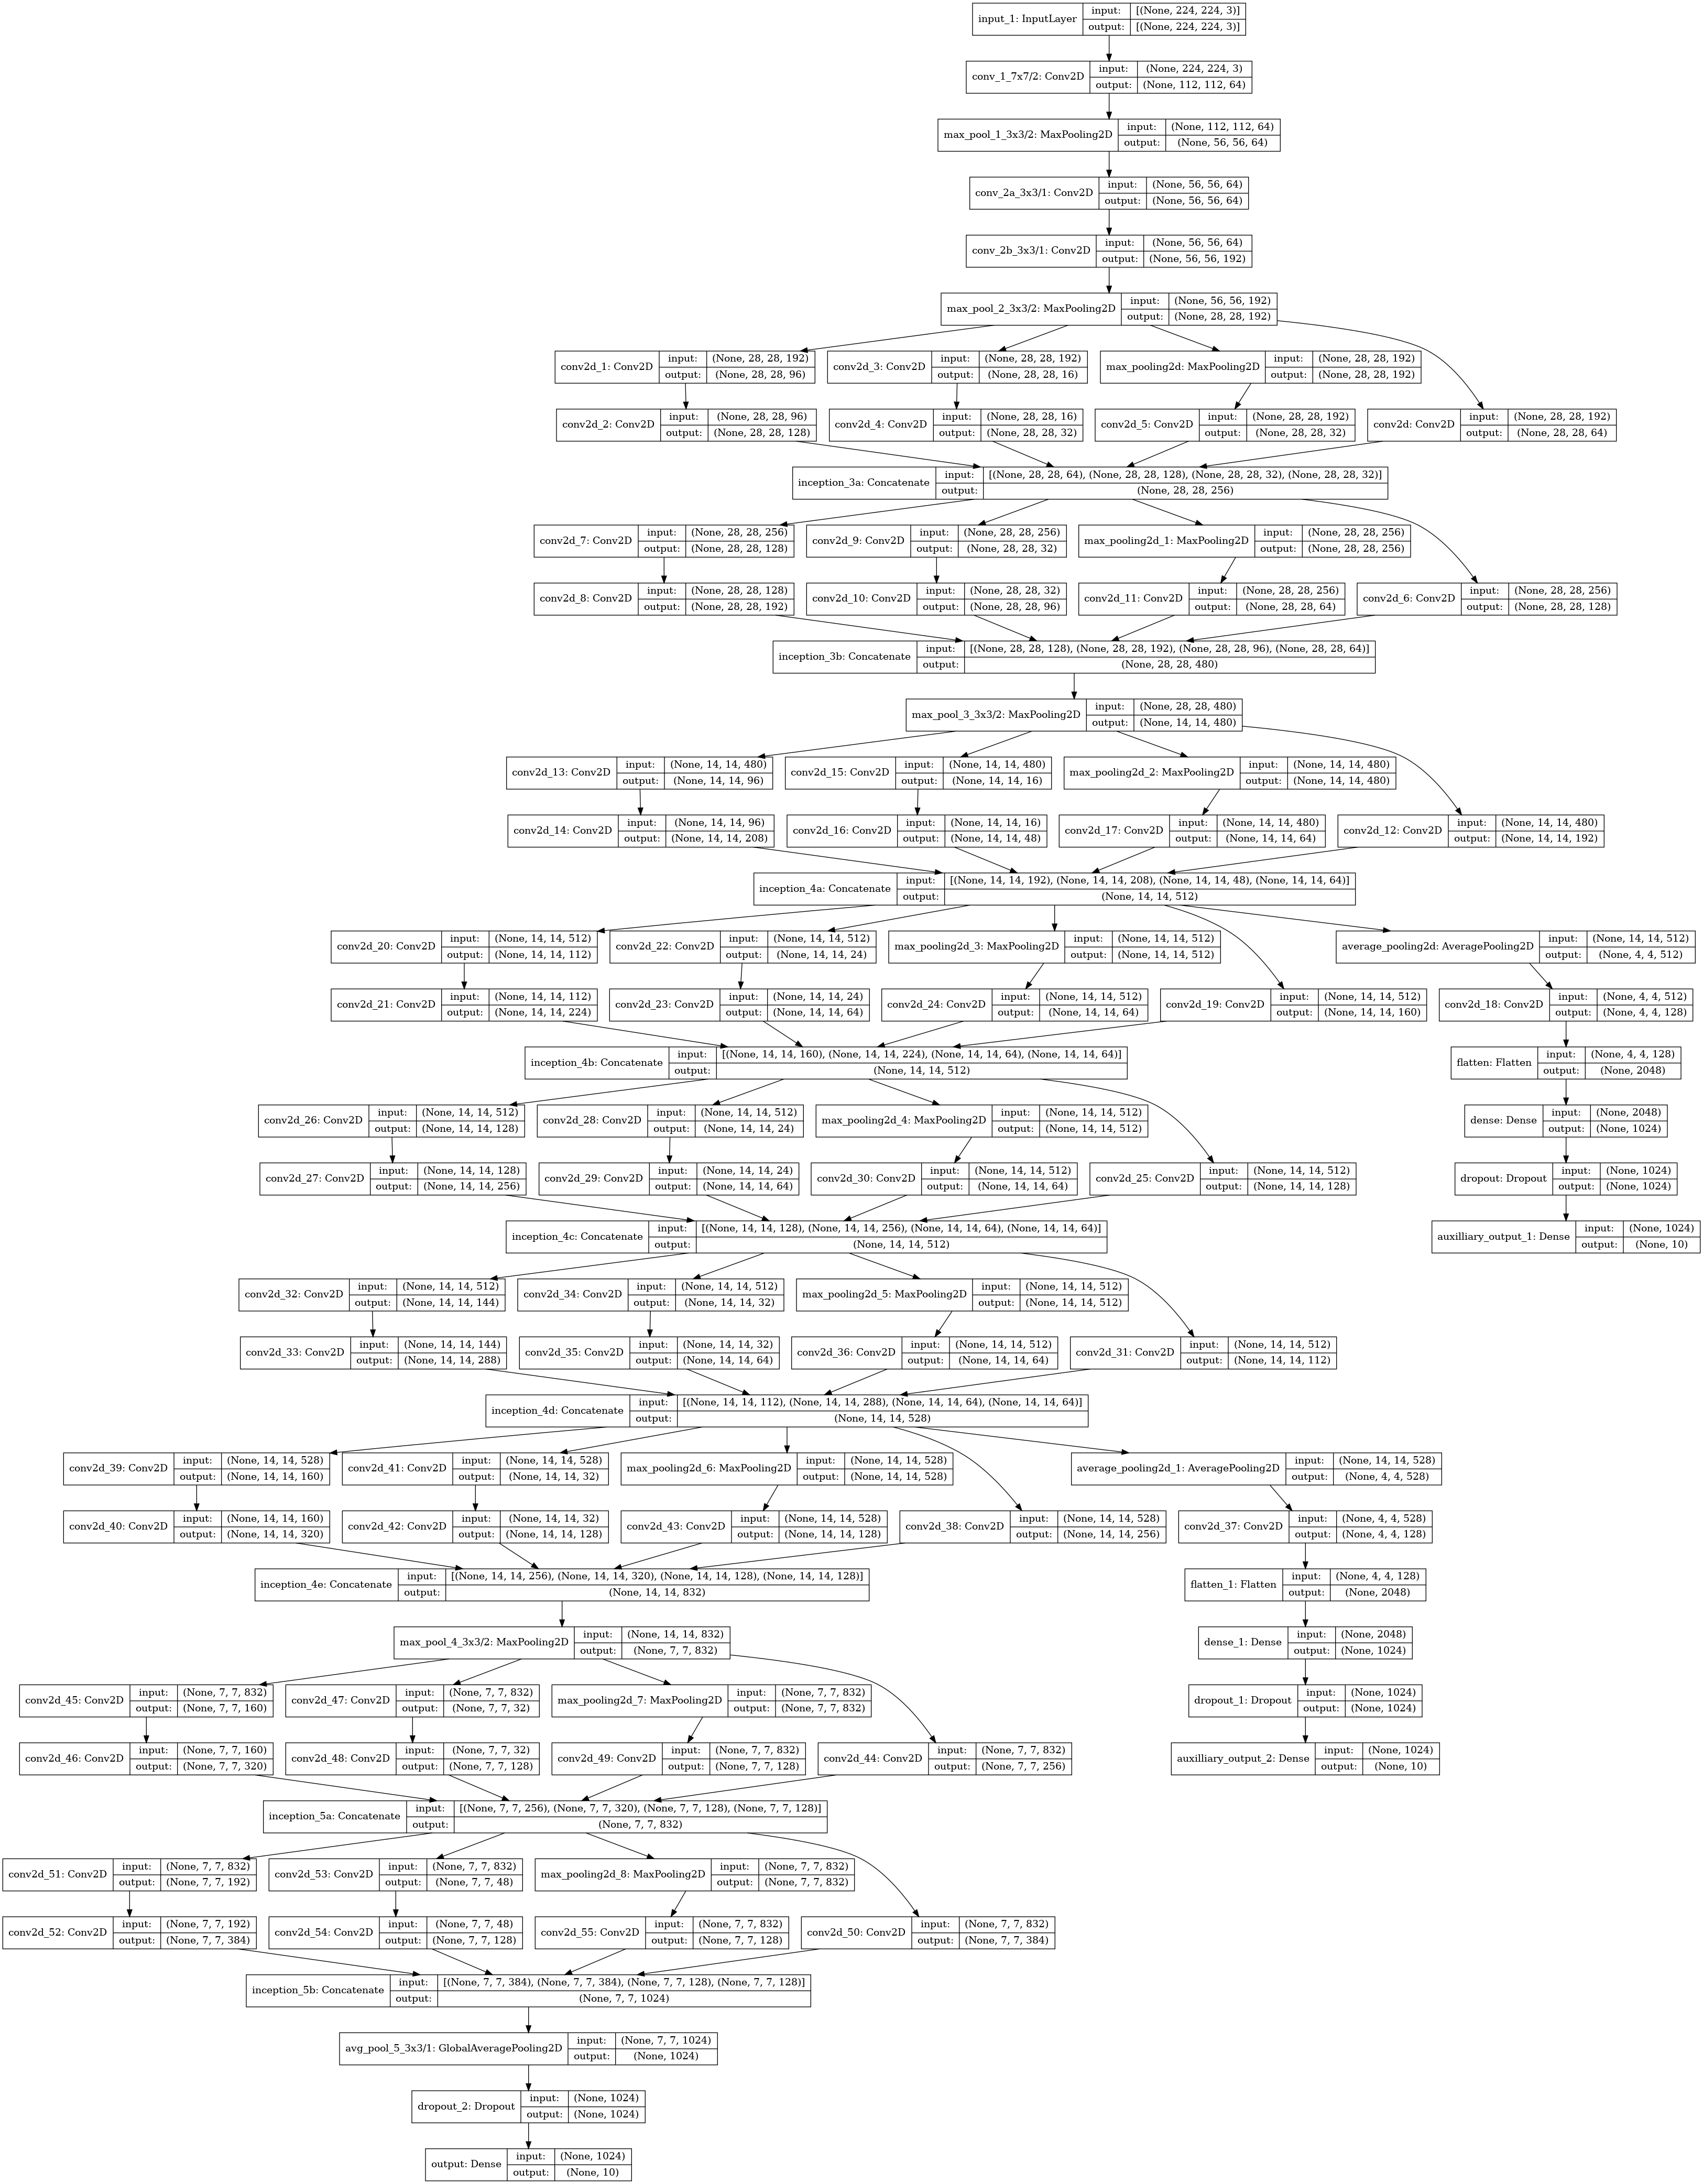

In [5]:
# Plotting the model architecture

plot_model(model, to_file="my_model.png", show_shapes=True)

---

## <center>3. Model Testing

In [6]:
# Moddel Training

# hisroty = model.fit(X_train, [Y_train, Y_train, Y_train],validation_data=(X_test, [y_test, y_test, y_test]), epochs=5, batch_size=256)

### COMMENTING THE TRAINING CODE AS IT THROWS MEMORY ALLOCATION ERROR

In [7]:
# Model Evaluation

# model.evaluate(test_x, test_y)

---

# <center>4. Project Outcomes & Conclusion

### Here are some of the key outcomes of the project:

- The Model Architecture was reconstructed from scratch with no errors.
- We were able to plot the model graph & observe input & output shapes of all the layers. 
- Also we could identify that the total trainable paramters for the Inception V1 model were 10M.
- To demonstrate it's functionality, we have tested the model for just 5 epochs (due to hardware limitations). 
- Despite this, the model has performed surpisingly well achieving high accuracy within few iterations.

In [8]:
#<<<--------------------------------------THE END---------------------------------------->>>